In [1]:
from imblearn.over_sampling import SMOTE, ADASYN
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import seaborn as sns; sns.set()
import ast


def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled


In [2]:
tickers = ['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX'] 
TREND_WINDOWs = [1, 4, 7, 14, 21, 28, 49]
newsPath = '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/'
pricePath = '/home/simone/Desktop/NLFF/indexes/indexes'



=======================  AAPL ============================

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................MCCs:  [-0.0409967551743227, -0.04892362694774127, -0.1284868127132788, -0.018397638399175683, -0.03303285479372514, 0.05258982858170546, 0.009834918388850672]
Accs:  [0.4921052631578947, 0.46437994722955145, 0.4312169312169312, 0.4641909

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................MCCs:  [-0.02054061596614523, 0.12913571587487144, 0.08310441602156388, 0.05784084989484095, 0.03169751559821946, 0.20244600090451276, 0.17300158530256393]
Accs:  [0.4789473684210526, 0.5646437994722955, 0.5396825396825397, 0.5251989389920424, 0.5159574468085106, 0.6016042780748663, 0.57837837837837

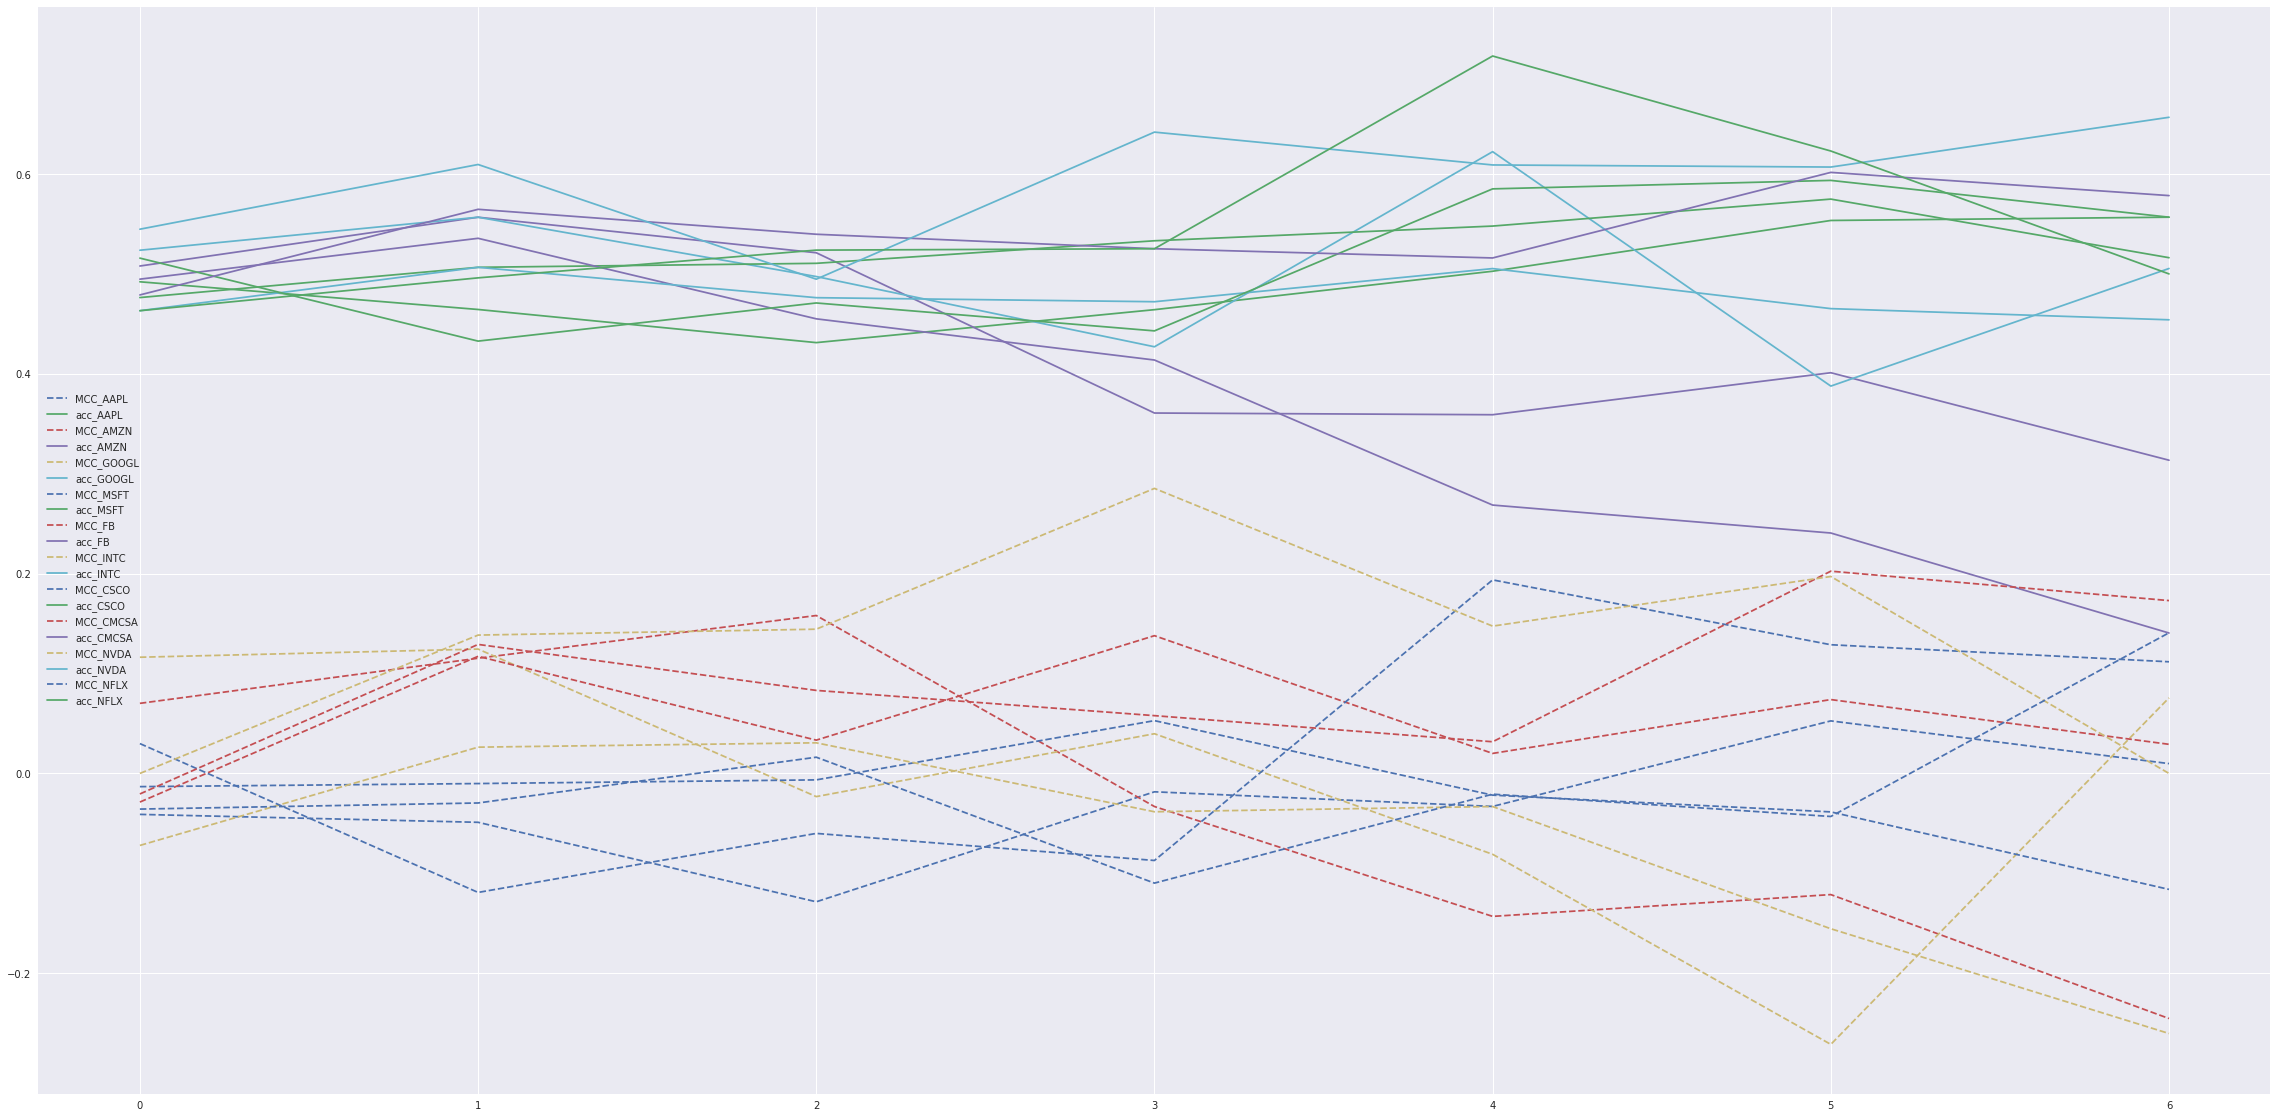

In [3]:
plt.figure(figsize=(40,20))
tic_Acc = {}
tic_MCC = {}
for ticker in tickers:
    print('\n\n======================= ',ticker,'============================\n')
    news =  pd.read_csv(newsPath+ticker+'.csv')
    price =  pd.read_csv(pricePath+ticker+'.csv')
    price = price.rename(index=str, columns={"date": "DATE"})
    news = news.rename(index=str, columns={"initTime": "DATE"})
    news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
    # This datased is already GMT+0
    price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
    #ALLIGNMENT
    initDate = datetime(2017,5,22,14,0,0)
    finalDate = datetime(2018,6,20,19,0,0)
    price.drop(price[price.DATE > finalDate].index, inplace=True)
    price.drop(price[price.DATE < initDate].index, inplace=True)
    price = price.reset_index(drop=True)
    news.drop(news[news.DATE > finalDate].index, inplace=True)
    news.drop(news[news.DATE < initDate].index, inplace=True)
    news = news.reset_index(drop=True)

    #Controllo allignment
    for data in news['DATE']:
        if data not in price['DATE'].tolist():
            print(data)
    assert len(price) == len(news)

    # FEATURES EXTRACTION
    sentiment = news.drop(['Unnamed: 0', 'DATE'], axis=1)
    X = pd.concat([sentiment, sentiment.rolling(5).mean()],axis=1)
    X = pd.concat([X, sentiment.rolling(10).mean()],axis=1)
    X = pd.concat([X, sentiment.rolling(15).mean()],axis=1)
    X = pd.concat([X, sentiment.rolling(20).mean()],axis=1)

    X = np.nan_to_num(np.asarray(X, dtype=float))
    min_max_scaler = preprocessing.MinMaxScaler()
    X = np.asarray(min_max_scaler.fit_transform(X))
    
    accs = list()
    MCCs = list()
    for TREND_WINDOW in TREND_WINDOWs:
        #CONSTRUCT LABELS
        y = list()
        x = list()
        up = 0
        down = 0
        for i in range(0,len(price)-TREND_WINDOW):
            s=np.sign(price.iloc[i+TREND_WINDOW]['close']-price.iloc[i]['close'])
            if(s==-1):
                y.append(0)
                down +=1
            else:
                y.append(1)
                up +=1
            x.append(X[i])
        
        
        #EXPERIMENT
        y = np.array(y)
        x = np.array(x)
        train=0.8
        nt=math.ceil(len(x)*train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        cSpace = np.logspace(-3,5,10)
        gSpace = np.logspace(-3,5,10)
        #MODEL SELECTION: CV
        best_c = 0
        best_g = 0
        best_acc = 0
        for c in range(0,10):
            for g in range(0,10):
                cvacclist = list()
                print('.', end='')
                trainpoint=math.floor(len(x_tv)*0.50)
                dimval=math.floor((len(x_tv)-trainpoint)*0.25)
                endval=trainpoint+dimval
                for i in range(0,4):
                    x_train = x_tv[0:trainpoint]
                    y_train = y_tv[0:trainpoint]
                    x_val = x_tv[trainpoint:endval]
                    y_val = y_tv[trainpoint:endval]
                    trainpoint = trainpoint+dimval
                    endval = endval+dimval
                    rbf_svm = svm.SVC(kernel='rbf',C=cSpace[c], gamma=gSpace[g])
                    x_train,y_train = smote(x_train,y_train)
                    x_val,y_val = smote(x_val,y_val)
                    rbf_svm.fit(x_train,y_train)
                    acc = rbf_svm.score(x_val,y_val)
                    cvacclist.append(acc)

                cvacc=sum(cvacclist)/len(cvacclist)
                if(cvacc > best_acc):
                    best_acc=cvacc
                    best_c = cSpace[c]
                    best_g = gSpace[g]
                    

        rbf_svm = svm.SVC(kernel='rbf',C=best_c, gamma=best_g)
        x_tv,y_tv = smote(x_tv,y_tv)
        rbf_svm.fit(x_tv,y_tv)
        y_pred = rbf_svm.predict(x_test)
        acc = rbf_svm.score(x_test,y_test)
        confmatrix = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = confmatrix.ravel()
        denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
        accs.append(acc)
        MCCs.append(0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom) )

    plt.plot(range(len(MCCs)), MCCs, label='MCC_'+ticker, linestyle='dashed')
    plt.plot(range(len(accs)), accs, label='acc_'+ticker)
    print('MCCs: ', MCCs)
    print('Accs: ',accs)
    tic_Acc[ticker] = accs
    tic_MCC[ticker] = MCCs
    
plt.legend()
plt.show()

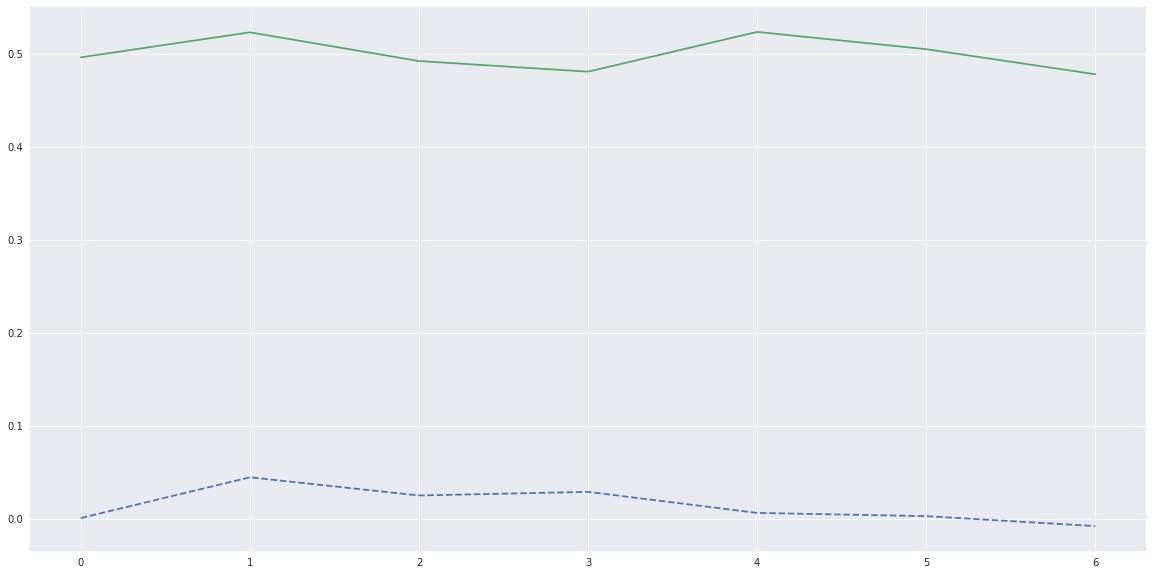

In [4]:
plt.figure(figsize=(20,10))

meanAcc = np.zeros([len(TREND_WINDOWs)])
for key, value in tic_Acc.items():
    meanAcc += np.asarray(value)/10

meanMCC = np.zeros([len(TREND_WINDOWs)])
for key, value in tic_MCC.items():
    meanMCC += np.asarray(value)/10

plt.plot(range(len(meanMCC)), meanMCC, label='MCC_mean', linestyle='dashed')
plt.plot(range(len(meanAcc)), meanAcc, label='Acc_mean')